# Image Captioning using CNNs & LSTMs

## Setup notebook


In [1]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import spacy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

from models import EncoderDecoderModel
from data import CocoCaptions, CocoCollate
from vocabulary import CocoCaptionsVocabulary
from utils import train


In [2]:
spacy.prefer_gpu()
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)


1.9.0+cu111
cuda:0


## COCO Dataset


### Download & extract the dataset


In [3]:
DATASET_DIR = Path("./datasets/coco")
MODEL_DIR = Path("./checkpoints/coco")
RESULTS_DIR = Path("./results/coco")

DATASET_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)


In [4]:
DATASET_URLS = [
    "http://images.cocodataset.org/zips/train2014.zip",
    "http://images.cocodataset.org/zips/val2014.zip",
    "http://images.cocodataset.org/zips/test2014.zip",
    "http://images.cocodataset.org/annotations/annotations_trainval2014.zip",
]

for url in DATASET_URLS:
    name, stem = Path(url).name, Path(url).stem
    if (DATASET_DIR / stem).exists():
        continue

    !wget -P {DATASET_DIR} {url}
    !tar -xf {DATASET_DIR / name} --directory {DATASET_DIR}


In [5]:
BATCH_SIZE = 32
EPOCHS = 1
HIDDEN_SIZE = 512
EMBED_SIZE = 512


### Build vocabulary from captions


In [6]:
vocab_path = MODEL_DIR / "vocab.pkl"

if vocab_path.exists():
    vocab: CocoCaptionsVocabulary = pickle.load(open(vocab_path, "rb"))

else:
    print("Building vocabulary...")
    annotation_file = DATASET_DIR / "annotations_trainval2014/captions_train2014.json"
    vocab = CocoCaptionsVocabulary(annotation_file=annotation_file)

    print("Saving vocabulary...")
    with open(vocab_path, "wb") as f:
        pickle.dump(vocab, f)



### Setup training and testing datasets

* We will normalize the data using the mean and stddev of the ImageNet dataset


In [7]:
transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize(
        #     (0.485, 0.456, 0.406),
        #     (0.229, 0.224, 0.225),
        # ),
    ]
)

train_dataset = CocoCaptions(
    root=DATASET_DIR / "train2014",
    annFile=DATASET_DIR / "annotations_trainval2014/captions_train2014.json",
    transform=transform,
    target_transform=vocab.encode,
)
valid_dataset = CocoCaptions(
    root=DATASET_DIR / "val2014",
    annFile=DATASET_DIR / "annotations_trainval2014/captions_val2014.json",
    transform=transform,
    target_transform=vocab.encode,
)

# ? Create dataset loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=CocoCollate(vocab.pad),
    shuffle=True,
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=CocoCollate(vocab.pad),
    shuffle=False,
)


loading annotations into memory...
Done (t=0.90s)
creating index...
index created!
loading annotations into memory...
Done (t=0.52s)
creating index...
index created!


### Visualize dataset


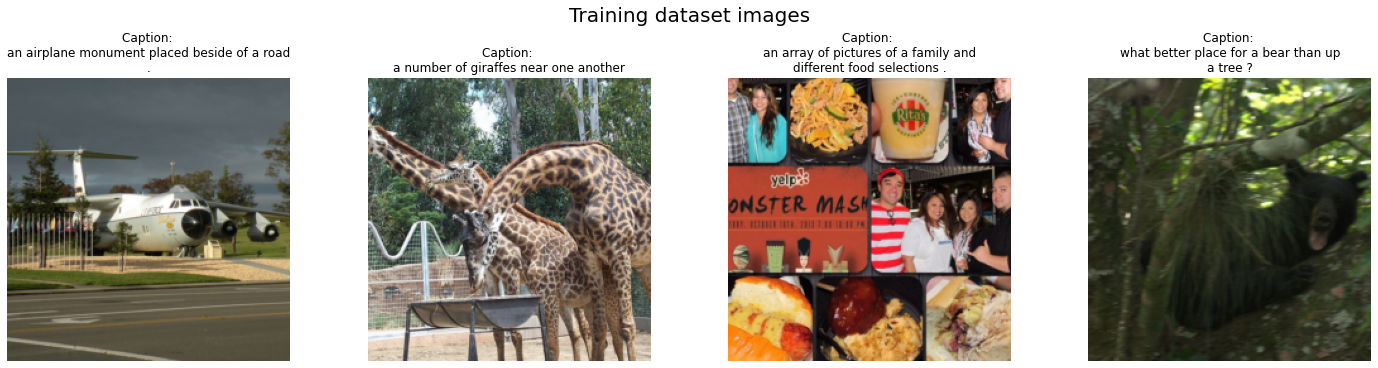

In [8]:
sample_images, sample_targets = next(iter(train_loader))

fig, axes = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=True)
fig.suptitle("Training dataset images", fontsize=20)

for i, ax in enumerate(axes):
    image, caption = sample_images[i], sample_targets[i]
    caption = vocab.decode(caption)

    words = caption.split()
    caption_multiple_lines = "\n".join([" ".join(words[i: i + 8]) for i in range(0, len(words), 8)])

    ax.imshow(image.permute(1, 2, 0))
    ax.axis("off")
    ax.set_title(f"Caption: \n{caption_multiple_lines}")

fig.savefig(RESULTS_DIR / "train_dataset.png", facecolor="w")


## Build & Train the Encoder-Decoder Model


In [9]:
model = EncoderDecoderModel(EMBED_SIZE, HIDDEN_SIZE, len(vocab)).to(device)
print(model)

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.pad).to(device)


EncoderDecoderModel(
  (encoderCNN): EncoderCNN(
    (inception): Inception3(
      (Conv2d_1a_3x3): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2a_3x3): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2b_3x3): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (Conv2d_3b_1x1): BasicConv2d(
        (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.

In [10]:
train_losses = train(
    model,
    train_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=100,
    device=device,
    save_dir=MODEL_DIR,
)


0it [00:00, ?it/s]

Training started...


C:\Python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
200it [01:51,  1.83it/s]

Epoch 1/100	| Batch 200/32 (1.5%)	| Loss: 5.333466


400it [03:37,  1.91it/s]

Epoch 1/100	| Batch 400/32 (3.1%)	| Loss: 6.089033


600it [05:23,  1.98it/s]

Epoch 1/100	| Batch 600/32 (4.6%)	| Loss: 5.499212


800it [07:19,  1.54it/s]

Epoch 1/100	| Batch 800/32 (6.2%)	| Loss: 5.641981


1000it [09:28,  1.56it/s]

Epoch 1/100	| Batch 1000/32 (7.7%)	| Loss: 5.767466


1200it [11:35,  1.58it/s]

Epoch 1/100	| Batch 1200/32 (9.3%)	| Loss: 5.459558


1400it [13:40,  1.61it/s]

Epoch 1/100	| Batch 1400/32 (10.8%)	| Loss: 5.466481


1600it [15:45,  1.64it/s]

Epoch 1/100	| Batch 1600/32 (12.4%)	| Loss: 5.613347


1800it [17:46,  1.66it/s]

Epoch 1/100	| Batch 1800/32 (13.9%)	| Loss: 5.560903


2000it [19:48,  1.67it/s]

Epoch 1/100	| Batch 2000/32 (15.5%)	| Loss: 5.507345


2200it [21:48,  1.68it/s]

Epoch 1/100	| Batch 2200/32 (17.0%)	| Loss: 5.887799


2400it [23:47,  1.64it/s]

Epoch 1/100	| Batch 2400/32 (18.5%)	| Loss: 5.275038


2600it [25:45,  1.69it/s]

Epoch 1/100	| Batch 2600/32 (20.1%)	| Loss: 5.380462


2800it [27:41,  1.78it/s]

Epoch 1/100	| Batch 2800/32 (21.6%)	| Loss: 5.723474


3000it [29:35,  1.78it/s]

Epoch 1/100	| Batch 3000/32 (23.2%)	| Loss: 5.388796


3200it [31:28,  1.75it/s]

Epoch 1/100	| Batch 3200/32 (24.7%)	| Loss: 6.550754


3400it [33:20,  1.81it/s]

Epoch 1/100	| Batch 3400/32 (26.3%)	| Loss: 6.455323


3600it [35:13,  1.68it/s]

Epoch 1/100	| Batch 3600/32 (27.8%)	| Loss: 5.668733


3800it [37:08,  1.78it/s]

Epoch 1/100	| Batch 3800/32 (29.4%)	| Loss: 5.918268


4000it [39:04,  1.73it/s]

Epoch 1/100	| Batch 4000/32 (30.9%)	| Loss: 5.434636


4200it [40:56,  1.81it/s]

Epoch 1/100	| Batch 4200/32 (32.5%)	| Loss: 5.644333


4400it [42:48,  1.81it/s]

Epoch 1/100	| Batch 4400/32 (34.0%)	| Loss: 6.601433


4600it [44:40,  1.76it/s]

Epoch 1/100	| Batch 4600/32 (35.5%)	| Loss: 5.146357


4800it [46:31,  1.79it/s]

Epoch 1/100	| Batch 4800/32 (37.1%)	| Loss: 6.953852


5000it [48:22,  1.82it/s]

Epoch 1/100	| Batch 5000/32 (38.6%)	| Loss: 5.572573


5200it [50:13,  1.78it/s]

Epoch 1/100	| Batch 5200/32 (40.2%)	| Loss: 5.942669


5400it [52:03,  1.82it/s]

Epoch 1/100	| Batch 5400/32 (41.7%)	| Loss: 5.581618


5600it [53:52,  1.87it/s]

Epoch 1/100	| Batch 5600/32 (43.3%)	| Loss: 5.033899


5800it [55:39,  1.89it/s]

Epoch 1/100	| Batch 5800/32 (44.8%)	| Loss: 5.375686


6000it [57:26,  1.86it/s]

Epoch 1/100	| Batch 6000/32 (46.4%)	| Loss: 5.317607


6200it [59:17,  2.07it/s]

Epoch 1/100	| Batch 6200/32 (47.9%)	| Loss: 5.586614


6400it [1:01:07,  1.89it/s]

Epoch 1/100	| Batch 6400/32 (49.5%)	| Loss: 5.720342


6600it [1:02:59,  1.79it/s]

Epoch 1/100	| Batch 6600/32 (51.0%)	| Loss: 6.628686


6800it [1:04:48,  1.85it/s]

Epoch 1/100	| Batch 6800/32 (52.5%)	| Loss: 5.251974


7000it [1:06:36,  1.83it/s]

Epoch 1/100	| Batch 7000/32 (54.1%)	| Loss: 5.359810


7189it [1:08:19,  1.82it/s]